### homework1：实战分类，实现早停，模型保存，模型加载

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)  #设备是cuda:0，即GPU，如果没有GPU则是cpu

sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)
matplotlib 3.10.0
numpy 2.0.2
pandas 2.2.3
sklearn 1.6.0
torch 2.5.1+cu124
cuda:0


数据准备

In [3]:
from torchvision import datasets
from torchvision.transforms import ToTensor

# fashion_mnist图像分类数据集
train_ds = datasets.FashionMNIST(
    root="../data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_ds = datasets.FashionMNIST(
    root="../data",
    train=False,
    download=True,
    transform=ToTensor()
)

# torchvision 数据集里没有提供训练集和验证集的划分
# 当然也可以用 torch.utils.data.Dataset 实现人为划分

In [4]:
# 从数据集到dataloader
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(test_ds, batch_size=32, shuffle=False)

定义模型

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 300),  # in_features=784, out_features=300
            nn.ReLU(),
            nn.Linear(300, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
        )

    def forward(self, x):
        # x.shape [batch size, 1, 28, 28]
        x = self.flatten(x)
        # 展平后 x.shape [batch size, 28 * 28]
        logits = self.linear_relu_stack(x)
        # logits.shape [batch size, 10]
        return logits


model = NeuralNetwork()

训练

In [6]:
from sklearn.metrics import accuracy_score


@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    loss_list = []
    pred_list = []
    label_list = []
    for datas, labels in dataloader:
        #datas.shape [batch size, 1, 28, 28]
        #labels.shape [batch size]
        datas = datas.to(device)
        labels = labels.to(device)
        # 前向计算
        logits = model(datas)
        loss = loss_fct(logits, labels)  # 验证集损失
        loss_list.append(loss.item())  # tensor.item() 获取tensor的数值，loss是只有一个元素的tensor

        preds = logits.argmax(
            axis=-1)  # 验证集预测, axis=-1 表示最后一个维度,因为logits.shape [batch size, 10]，所以axis=-1表示对最后一个维度求argmax，即对每个样本的10个类别的概率求argmax，得到最大概率的类别, preds.shape [batch size]
        pred_list.extend(preds.cpu().numpy().tolist())  # tensor转numpy，再转list
        label_list.extend(labels.cpu().numpy().tolist())

    acc = accuracy_score(label_list, pred_list)  # 验证集准确率
    return np.mean(loss_list), acc  # 返回验证集平均损失和准确率

TensorBoard 可视化  tensorboard --logdir="G:\my_first_github\homework\runs"

In [8]:
from torch.utils.tensorboard import SummaryWriter
import torch  # 需要导入torch以使用torch.randn

class TensorBoardCallback:
    def __init__(self, log_dir, flush_secs=10):
        """
        初始化TensorBoardCallback类。

        Args:
            log_dir (str): 日志文件存放的目录。
            flush_secs (int, optional): 每隔多少秒将日志写入磁盘。默认为10秒。
        """
        self.writer = SummaryWriter(log_dir=log_dir, flush_secs=flush_secs)  # 实例化SummaryWriter

    def draw_model(self, model, input_shape):
        """
        绘制模型的计算图。

        Args:
            model (torch.nn.Module): 要绘制的模型。
            input_shape (tuple): 输入张量的形状，用于生成随机输入。
        """
        self.writer.add_graph(model, input_to_model=torch.randn(input_shape))  # 画模型图

    def add_loss_scalars(self, step, loss, val_loss):
        """
        添加训练和验证损失到TensorBoard。

        Args:
            step (int): 当前的训练步数。
            loss (float): 训练损失。
            val_loss (float): 验证损失。
        """
        self.writer.add_scalars(
            main_tag="training/loss",
            tag_scalar_dict={"loss": loss, "val_loss": val_loss},
            global_step=step,
        )  # 画loss曲线

    def add_acc_scalars(self, step, acc, val_acc):
        """
        添加训练和验证准确率到TensorBoard。

        Args:
            step (int): 当前的训练步数。
            acc (float): 训练准确率。
            val_acc (float): 验证准确率。
        """
        self.writer.add_scalars(
            main_tag="training/accuracy",
            tag_scalar_dict={"accuracy": acc, "val_accuracy": val_acc},
            global_step=step,
        )  # 画acc曲线

    def add_lr_scalars(self, step, learning_rate):
        """
        添加学习率到TensorBoard。

        Args:
            step (int): 当前的训练步数。
            learning_rate (float): 当前的学习率。
        """
        self.writer.add_scalars(
            main_tag="training/learning_rate",
            tag_scalar_dict={"learning_rate": learning_rate},
            global_step=step,
        )  # 画lr曲线

    def __call__(self, step, **kwargs):
        """
        调用类实例时执行的方法，用于批量添加损失、准确率和学习率到TensorBoard。

        Args:
            step (int): 当前的训练步数。
            **kwargs: 包含损失、准确率和学习率的字典。
        """
        # 添加损失
        loss = kwargs.pop("loss", None)
        val_loss = kwargs.pop("val_loss", None)
        if loss is not None and val_loss is not None:
            self.add_loss_scalars(step, loss, val_loss)  # 画loss曲线

        # 添加准确率
        acc = kwargs.pop("acc", None)
        val_acc = kwargs.pop("val_acc", None)
        if acc is not None and val_acc is not None:
            self.add_acc_scalars(step, acc, val_acc)  # 画acc曲线

        # 添加学习率
        learning_rate = kwargs.pop("lr", None)
        if learning_rate is not None:
            self.add_lr_scalars(step, learning_rate)  # 画lr曲线

Save Best

In [9]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=500, save_best_only=True):
        """
        初始化SaveCheckpointsCallback类，用于保存训练过程中的模型检查点。

        Args:
            save_dir (str): 检查点保存的目录。
            save_step (int, optional): 每隔多少步保存一次检查点。默认为500步。
            save_best_only (bool, optional): 如果为True，则只保存性能最好的模型；否则每隔save_step步保存一次模型。默认为True。
        """
        self.save_dir = save_dir  # 检查点保存路径
        self.save_step = save_step  # 保存检查点的步数间隔
        self.save_best_only = save_best_only  # 是否只保存最好的模型
        self.best_metrics = -1  # 记录最好的性能指标，初始化为-1（假设指标为非负数）

        # 创建保存目录
        if not os.path.exists(self.save_dir):  # 如果保存目录不存在，则创建
            os.mkdir(self.save_dir)

    def __call__(self, step, state_dict, metric=None):
        """
        调用类实例时执行的方法，用于保存模型检查点。

        Args:
            step (int): 当前的训练步数。
            state_dict (dict): 模型的state_dict，包含模型参数。
            metric (float, optional): 当前模型的性能指标（如验证集准确率）。如果save_best_only为True，则必须提供该参数。
        """
        if step % self.save_step > 0:  # 每隔save_step步保存一次
            return

        if self.save_best_only:
            assert metric is not None, "metric must be provided when save_best_only is True"  # 必须传入metric
            if metric >= self.best_metrics:  # 如果当前指标比之前的最好指标更好
                # 保存检查点
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))  # 保存最好的模型
                # 更新最好的指标
                self.best_metrics = metric
        else:
            # 保存当前步数的模型
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))  # 保存每个step的模型

Early Stop

In [10]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        """
        初始化EarlyStopCallback类，用于实现早停机制。

        Args:
            patience (int, optional): 在多少个epoch没有提升后停止训练。默认为5。
            min_delta (float, optional): 监控指标的最小变化量，只有超过这个变化量才被认为是提升。默认为0.01。
        """
        self.patience = patience  # 允许的没有提升的epoch数
        self.min_delta = min_delta  # 监控指标的最小变化量
        self.best_metric = -1  # 记录最好的监控指标值，初始化为-1（假设指标为非负数）
        self.counter = 0  # 计数器，记录没有提升的epoch数

    def __call__(self, metric):
        """
        调用类实例时执行的方法，用于更新监控指标并判断是否需要早停。

        Args:
            metric (float): 当前的监控指标值（如验证集准确率）。
        """
        if metric >= self.best_metric + self.min_delta:  # 如果当前指标比最好指标有显著提升
            self.best_metric = metric  # 更新最好的指标值
            self.counter = 0  # 重置计数器
        else:
            self.counter += 1  # 如果没有提升，计数器加1

    @property
    def early_stop(self):
        """
        判断是否需要早停。

        Returns:
            bool: 如果计数器超过patience，则返回True，表示需要早停；否则返回False。
        """
        return self.counter >= self.patience

In [11]:
def training(
        model,
        train_loader,
        val_loader,
        epoch,
        loss_fct,
        optimizer,
        tensorboard_callback=None,
        save_ckpt_callback=None,
        early_stop_callback=None,
        eval_step=500,
):
    """
    训练模型的主函数。

    Args:
        model (torch.nn.Module): 要训练的模型。
        train_loader (torch.utils.data.DataLoader): 训练数据加载器。
        val_loader (torch.utils.data.DataLoader): 验证数据加载器。
        epoch (int): 训练的epoch数。
        loss_fct (torch.nn.Module): 损失函数。
        optimizer (torch.optim.Optimizer): 优化器。
        tensorboard_callback (callable, optional): TensorBoard回调函数，用于记录训练过程。默认为None。
        save_ckpt_callback (callable, optional): 保存模型检查点的回调函数。默认为None。
        early_stop_callback (callable, optional): 早停回调函数，用于监控验证集性能并决定是否提前停止训练。默认为None。
        eval_step (int, optional): 每隔多少步进行一次验证。默认为500。

    Returns:
        dict: 包含训练和验证过程中记录的损失和准确率的字典。
    """
    record_dict = {
        "train": [],  # 记录训练过程中的损失和准确率
        "val": []  # 记录验证过程中的损失和准确率
    }

    global_step = 0  # 全局步数，用于记录训练的总步数
    model.train()  # 将模型设置为训练模式
    with tqdm(total=epoch * len(train_loader)) as pbar:  # 使用tqdm显示进度条
        for epoch_id in range(epoch):  # 遍历每个epoch
            # 训练阶段
            for datas, labels in train_loader:  # 遍历训练数据加载器
                datas = datas.to(device)  # 将数据移动到指定设备（如GPU）
                labels = labels.to(device)  # 将标签移动到指定设备

                # 梯度清零
                optimizer.zero_grad()

                # 模型前向计算
                logits = model(datas)

                # 计算损失
                loss = loss_fct(logits, labels)

                # 反向传播，计算梯度
                loss.backward()

                # 更新模型参数
                optimizer.step()

                # 计算预测结果
                preds = logits.argmax(axis=-1)

                # 计算准确率
                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())

                # 将损失值从GPU移动到CPU并转换为Python数值
                loss = loss.cpu().item()

                # 记录训练结果
                record_dict["train"].append({
                    "loss": loss,  # 训练损失
                    "acc": acc,  # 训练准确率
                    "step": global_step  # 当前步数
                })

                # 验证阶段
                if global_step % eval_step == 0:  # 每隔eval_step步进行一次验证
                    model.eval()  # 将模型设置为评估模式
                    val_loss, val_acc = evaluating(model, val_loader, loss_fct)  # 在验证集上评估模型
                    record_dict["val"].append({
                        "loss": val_loss,  # 验证损失
                        "acc": val_acc,  # 验证准确率
                        "step": global_step  # 当前步数
                    })
                    model.train()  # 将模型切换回训练模式

                    # 1. 使用TensorBoard记录训练过程
                    if tensorboard_callback is not None:
                        tensorboard_callback(
                            global_step,
                            loss=loss, val_loss=val_loss,  # 训练和验证损失
                            acc=acc, val_acc=val_acc,  # 训练和验证准确率
                            lr=optimizer.param_groups[0]["lr"],  # 当前学习率
                        )

                    # 2. 保存模型检查点
                    if save_ckpt_callback is not None:
                        save_ckpt_callback(global_step, model.state_dict(), metric=val_acc)  # 保存模型权重

                    # 3. 早停机制
                    if early_stop_callback is not None:
                        early_stop_callback(val_acc)  # 更新早停状态
                        if early_stop_callback.early_stop:  # 判断是否需要早停
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict  # 如果触发早停，则返回记录结果

                # 更新全局步数
                global_step += 1
                pbar.update(1)  # 更新进度条
                pbar.set_postfix({"epoch": epoch_id})  # 在进度条中显示当前epoch

    return record_dict  # 返回训练和验证记录

In [16]:
# 设置训练的epoch数
epoch = 100

# 实例化神经网络模型
model = NeuralNetwork()

# 1. 定义损失函数，采用交叉熵损失（CrossEntropyLoss）
# 交叉熵损失通常用于分类任务，计算模型输出与真实标签之间的差异
loss_fct = nn.CrossEntropyLoss()

# 2. 定义优化器，采用随机梯度下降（SGD）
# SGD优化器通过梯度下降更新模型参数，lr是学习率，momentum是动量参数
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 1. TensorBoard可视化
# 实例化TensorBoardCallback，用于记录训练过程中的损失、准确率等指标
tensorboard_callback = TensorBoardCallback("runs")
# 绘制模型的计算图，输入形状为[1, 28, 28]，假设输入是单通道28x28的图像
tensorboard_callback.draw_model(model, [1, 28, 28])

# 2. 保存最佳模型检查点
# 实例化SaveCheckpointsCallback，用于保存训练过程中性能最好的模型
# save_best_only=True表示只保存性能最好的模型
save_ckpt_callback = SaveCheckpointsCallback("checkpoints", save_best_only=True)

# 3. 早停机制
# 实例化EarlyStopCallback，用于监控验证集性能并在性能不再提升时提前停止训练
# patience=10表示允许10个epoch内验证集性能没有提升
early_stop_callback = EarlyStopCallback(patience=10)

In [13]:
list(model.parameters())[1]  #可学习的模型参数

Parameter containing:
tensor([-0.0309,  0.0270, -0.0034,  0.0082,  0.0353,  0.0137, -0.0314,  0.0070,
        -0.0068, -0.0321, -0.0343,  0.0250, -0.0189, -0.0140, -0.0326,  0.0090,
         0.0064, -0.0337,  0.0099, -0.0152,  0.0128, -0.0248, -0.0068,  0.0105,
         0.0150,  0.0309, -0.0022, -0.0206, -0.0058,  0.0225, -0.0084,  0.0271,
        -0.0276,  0.0125, -0.0030,  0.0152, -0.0056, -0.0051,  0.0338,  0.0267,
        -0.0020,  0.0162, -0.0282,  0.0260, -0.0024, -0.0108,  0.0298, -0.0149,
        -0.0329, -0.0292, -0.0042, -0.0088,  0.0135,  0.0301,  0.0210, -0.0206,
        -0.0014, -0.0257,  0.0213, -0.0160, -0.0328,  0.0034, -0.0074,  0.0080,
         0.0063, -0.0212,  0.0297, -0.0300,  0.0076,  0.0058,  0.0049,  0.0118,
         0.0070, -0.0254, -0.0027, -0.0347, -0.0303,  0.0177,  0.0301,  0.0275,
         0.0104, -0.0204, -0.0208,  0.0205, -0.0072,  0.0321,  0.0242, -0.0322,
         0.0226,  0.0262,  0.0356,  0.0040,  0.0274,  0.0069, -0.0077, -0.0036,
        -0.0103, -

In [14]:
model.state_dict().keys()

odict_keys(['linear_relu_stack.0.weight', 'linear_relu_stack.0.bias', 'linear_relu_stack.2.weight', 'linear_relu_stack.2.bias', 'linear_relu_stack.4.weight', 'linear_relu_stack.4.bias'])

In [17]:
# 将模型移动到指定设备（如GPU）
model = model.to(device)

# 打印模型参数的设备信息，检查模型是否在GPU上
# next(model.parameters()) 返回模型的第一个参数，.device 属性显示该参数所在的设备
print(next(model.parameters()).device)  # 输出示例：cuda:0（表示在GPU上）或cpu（表示在CPU上）

# 调用训练函数，开始训练模型
record = training(
    model,  # 要训练的模型
    train_loader,  # 训练数据加载器
    val_loader,  # 验证数据加载器
    epoch,  # 训练的epoch数
    loss_fct,  # 损失函数
    optimizer,  # 优化器
    tensorboard_callback=tensorboard_callback,  # TensorBoard回调函数，用于记录训练过程
    save_ckpt_callback=save_ckpt_callback,  # 保存模型检查点的回调函数
    early_stop_callback=early_stop_callback,  # 早停回调函数，用于监控验证集性能
    eval_step=1000  # 每隔1000步进行一次验证
)

cuda:0


  0%|          | 0/187500 [00:00<?, ?it/s]

Early stop at epoch 17 / global_step 32000


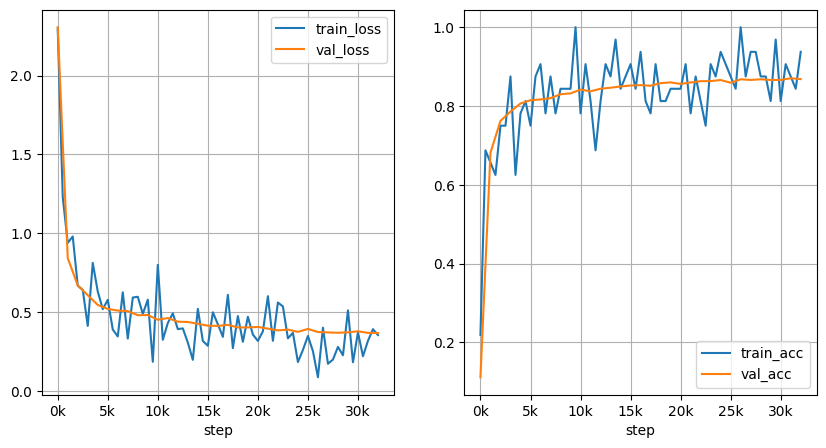

In [18]:
def plot_learning_curves(record_dict, sample_step=500):
    """
    绘制学习曲线，包括训练和验证的损失和准确率。

    Args:
        record_dict (dict): 包含训练和验证过程中记录的损失和准确率的字典。
        sample_step (int, optional): 对训练数据进行采样的步长间隔。默认为500。
    """
    # 将训练和验证记录转换为DataFrame
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]  # 对训练数据进行采样
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")  # 验证数据不需要采样

    # 绘制图表
    fig_num = len(train_df.columns)  # 子图数量，根据记录的指标数量决定（如loss和acc）
    fig, axs = plt.subplots(1, fig_num, figsize=(5 * fig_num, 5))  # 创建子图，figsize是子图大小

    # 遍历每个指标（如loss和acc）
    for idx, item in enumerate(train_df.columns):
        # 绘制训练和验证曲线
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")  # 训练曲线
        axs[idx].plot(val_df.index, val_df[item], label=f"val_{item}")  # 验证曲线
        axs[idx].grid()  # 添加网格
        axs[idx].legend()  # 添加图例

        # 设置x轴刻度和标签
        x_data = range(0, train_df.index[-1], 5000)  # 每隔5000步设置一个刻度
        axs[idx].set_xticks(x_data)  # 设置x轴刻度
        axs[idx].set_xticklabels(map(lambda x: f"{int(x / 1000)}k", x_data))  # 将刻度标签转换为“k”格式（如10k）
        axs[idx].set_xlabel("step")  # 设置x轴标签

    plt.show()  # 显示图表


# 调用函数绘制学习曲线
plot_learning_curves(record, sample_step=500)  # 横坐标是step，采样间隔为500

In [19]:
model = NeuralNetwork()  #上线时加载模型
model = model.to(device)

In [20]:
# dataload for evaluating
# 模型保存有两种情况：一种是模型结构和模型参数都保存，另一种是只保存模型参数，这时需要设置weights_only=True
# load checkpoints

# 加载保存的最佳模型权重
# torch.load("checkpoints/best.ckpt", map_location="cpu", weights_only=True) 从指定路径加载模型权重
# map_location="cpu" 表示将权重加载到CPU上（即使模型原本在GPU上训练）
# weights_only=True 表示只加载权重，不加载其他信息（如优化器状态）
model.load_state_dict(torch.load("checkpoints/best.ckpt", map_location="cpu", weights_only=True))

# 将模型设置为评估模式
# 在评估模式下，模型会禁用一些特定于训练的操作（如Dropout和BatchNorm的随机性）
model.eval()

# 在验证集上评估模型性能
# evaluating 是一个自定义函数，用于计算模型在验证集上的损失和准确率
loss, acc = evaluating(model, val_loader, loss_fct)

# 打印验证集上的损失和准确率
# :.4f 表示将浮点数格式化为保留4位小数
print(f"loss:     {loss:.4f}\naccuracy: {acc:.4f}")

loss:     0.3679
accuracy: 0.8704


### homework2：实战回归

In [21]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)
    
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)
matplotlib 3.10.0
numpy 2.0.2
pandas 2.2.3
sklearn 1.6.0
torch 2.5.1+cu124
cuda:0


准备数据

In [22]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing(data_home='../data')
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [45]:
print(housing.data[0:2])

[[ 8.32520000e+00  4.10000000e+01  6.98412698e+00  1.02380952e+00
   3.22000000e+02  2.55555556e+00  3.78800000e+01 -1.22230000e+02]
 [ 8.30140000e+00  2.10000000e+01  6.23813708e+00  9.71880492e-01
   2.40100000e+03  2.10984183e+00  3.78600000e+01 -1.22220000e+02]]


In [46]:
print(housing.target[0:2])

[4.526 3.585]


In [24]:
import pprint  #打印的格式比较 好看

pprint.pprint(housing.data[0:2])
print('-'*50)
pprint.pprint(housing.target[0:2])

array([[ 8.32520000e+00,  4.10000000e+01,  6.98412698e+00,
         1.02380952e+00,  3.22000000e+02,  2.55555556e+00,
         3.78800000e+01, -1.22230000e+02],
       [ 8.30140000e+00,  2.10000000e+01,  6.23813708e+00,
         9.71880492e-01,  2.40100000e+03,  2.10984183e+00,
         3.78600000e+01, -1.22220000e+02]])
--------------------------------------------------
array([4.526, 3.585])


In [25]:
from sklearn.model_selection import train_test_split

#拆分训练集和测试集，random_state是随机种子,同样的随机数种子，是为了得到同样的随机值
x_train_all, x_test, y_train_all, y_test = train_test_split(
    housing.data, housing.target, random_state = 7)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all, random_state = 11)
# 训练集
print(x_train.shape, y_train.shape)
# 验证集
print(x_valid.shape, y_valid.shape)
# 测试集
print(x_test.shape, y_test.shape)

dataset_maps = {
    "train": [x_train, y_train],
    "valid": [x_valid, y_valid],
    "test": [x_test, y_test],
} # 把3个数据集都放到字典中

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [26]:
type(x_train)

numpy.ndarray

In [47]:
from sklearn.preprocessing import StandardScaler

# 实例化 StandardScaler 对象
# StandardScaler 用于对数据进行标准化处理，即将数据转换为均值为0、标准差为1的分布
scaler = StandardScaler()

# 对训练数据进行拟合（fit）
# fit 方法计算训练数据的均值和标准差，但不进行实际的转换

# fit 后的变化：
# 计算 x_train 的均值（mean_）和标准差（scale_）。
# 将这些值存储在 scaler 对象中
scaler.fit(x_train)

# print("Mean:", scaler.mean_)        # 均值
# print("Scale:", scaler.scale_)      # 标准差

# 解释 fit 和 fit_transform 的区别：
# 1. fit: 仅计算数据的均值和标准差，不进行转换。
#    例如，scaler.fit(x_train) 会计算 x_train 的均值和标准差，并存储在 scaler 对象中。
# 2. fit_transform: 先调用 fit 方法计算均值和标准差，然后对数据进行转换。
#    例如，x_train_scaled = scaler.fit_transform(x_train) 会先计算 x_train 的均值和标准差，
#    然后将其转换为标准化后的数据。

# 如果需要同时对训练数据进行拟合和转换，可以使用 fit_transform 方法：
# x_train_scaled = scaler.fit_transform(x_train)

# 对测试数据进行转换（transform）
# 使用训练数据计算的均值和标准差对测试数据进行标准化
# x_test_scaled = scaler.transform(x_test)

Mean: [ 3.84070640e+00  2.86022394e+01  5.42064893e+00  1.09920545e+00
  1.42854496e+03  3.03541087e+00  3.56440405e+01 -1.19574947e+02]
Scale: [1.87674415e+00 1.24843576e+01 2.45373908e+00 5.07522623e-01
 1.10218806e+03 7.29416504e+00 2.14330586e+00 2.00261626e+00]


In [28]:
np.array(1).shape

()

构建数据集

In [29]:
#构建私有数据集，就需要用如下方式
from torch.utils.data import Dataset

# 自定义数据集类 HousingDataset，继承自 PyTorch 的 Dataset
class HousingDataset(Dataset):
    def __init__(self, mode='train'):
        """
        初始化 HousingDataset 类。

        Args:
            mode (str, optional): 数据集模式，可以是 'train'、'valid' 或 'test'。默认为 'train'。
        """
        # 从全局变量 dataset_maps 中加载对应模式的数据
        # dataset_maps 是一个字典，键是模式（如 'train'、'valid'、'test'），值是对应的 (x, y) 数据
        self.x, self.y = dataset_maps[mode]  # x 是特征数据，y 是标签数据，都是 NumPy 数组

        # 对特征数据 x 进行标准化处理
        # scaler 是一个预定义的标准化对象（如 StandardScaler），用于将数据转换为均值为 0、标准差为 1 的分布
        # torch.from_numpy 将 NumPy 数组转换为 PyTorch 张量，.float() 将张量转换为浮点类型
        self.x = torch.from_numpy(scaler.transform(self.x)).float()

        # 对标签数据 y 进行处理
        # torch.from_numpy 将 NumPy 数组转换为 PyTorch 张量，.float() 将张量转换为浮点类型
        # .reshape(-1, 1) 将标签数据转换为多行 1 列的张量（即列向量）
        self.y = torch.from_numpy(self.y).float().reshape(-1, 1)

    def __len__(self):
        """
        返回数据集的长度。

        Returns:
            int: 数据集的样本数量。
        """
        return len(self.x)  # 返回特征数据 x 的长度（即样本数量）

    def __getitem__(self, idx):
        """
        根据索引返回数据集中的一个样本。

        Args:
            idx (int): 样本的索引。

        Returns:
            tuple: 一个包含特征数据和标签数据的元组 (x[idx], y[idx])。
        """
        return self.x[idx], self.y[idx]  # 返回第 idx 个样本的特征和标签


# 创建训练集、验证集和测试集
# train_ds、valid_ds 和 test_ds 是 HousingDataset 的实例，分别对应训练、验证和测试数据
# 这些数据集与前面例子中的 FashionMNIST 数据集类型一致，可以直接用于 PyTorch 的 DataLoader
train_ds = HousingDataset("train")  # 训练集
valid_ds = HousingDataset("valid")  # 验证集
test_ds = HousingDataset("test")    # 测试集

In [30]:
train_ds[0]

(tensor([ 0.8015,  0.2722, -0.1162, -0.2023, -0.5431, -0.0210, -0.5898, -0.0824]),
 tensor([3.2260]))

In [31]:
train_ds[0][0]

tensor([ 0.8015,  0.2722, -0.1162, -0.2023, -0.5431, -0.0210, -0.5898, -0.0824])

DataLoader

In [32]:
from torch.utils.data import DataLoader

#放到DataLoader中的train_ds, valid_ds, test_ds都是dataset类型的数据
batch_size = 16
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

定义模型

In [33]:
#回归模型我们只需要1个数

class NeuralNetwork(nn.Module):
    def __init__(self, input_dim=8):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, 30),
            nn.ReLU(),
            nn.Linear(30, 1)
            )
        
    def forward(self, x):
        # x.shape [batch size, 8]
        logits = self.linear_relu_stack(x)
        # logits.shape [batch size, 1]
        return logits

In [34]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        """

        Args:
            patience (int, optional): Number of epochs with no improvement after which training will be stopped.. Defaults to 5.
            min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute 
                change of less than min_delta, will count as no improvement. Defaults to 0.01.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = -1
        self.counter = 0
        
    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter 
            self.counter = 0
        else: 
            self.counter += 1
            
    @property
    def early_stop(self):
        return self.counter >= self.patience

In [35]:
from sklearn.metrics import accuracy_score

@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    loss_list = []
    for datas, labels in dataloader:
        datas = datas.to(device)
        labels = labels.to(device)
        # 前向计算
        logits = model(datas)
        loss = loss_fct(logits, labels)         # 验证集损失
        loss_list.append(loss.item())
        
    return np.mean(loss_list)

In [36]:
# 训练
def training(
    model, 
    train_loader, 
    val_loader, 
    epoch, 
    loss_fct, 
    optimizer,
    early_stop_callback=None,
    eval_step=500,
    ):
    record_dict = {
        "train": [],
        "val": []
    }
    
    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:#11610/16=725
                datas = datas.to(device)
                labels = labels.to(device)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits = model(datas) #得到预测值
                # 计算损失
                loss = loss_fct(logits, labels)
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()
 
                loss = loss.cpu().item() #转为cpu类型，item()是取值
                # record
                
                record_dict["train"].append({
                    "loss": loss, "step": global_step
                })
                
                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "step": global_step
                    })
                    model.train()

                    # 早停 Early Stop
                    if early_stop_callback is not None:
                        early_stop_callback(-val_loss) #根据验证集的损失来实现早停
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}", flush=True)
                            return record_dict
                    
                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})
        
    return record_dict

In [37]:
# 设置训练的 epoch 数
epoch = 100

# 实例化神经网络模型
model = NeuralNetwork()

# 1. 定义损失函数，采用均方误差损失（MSE Loss）
# 均方误差损失用于回归任务，计算模型输出与真实标签之间的平方差
loss_fct = nn.MSELoss()

# 2. 定义优化器，采用随机梯度下降（SGD）
# SGD 优化器通过梯度下降更新模型参数
# lr=0.001 是学习率，momentum=0.9 是动量参数，用于加速收敛
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 3. 早停机制
# 实例化 EarlyStopCallback，用于监控验证集性能并在性能不再提升时提前停止训练
# patience=10 表示允许 10 个 epoch 内验证集性能没有显著提升
# min_delta=1e-3 表示验证集性能的最小提升幅度，小于该值则不认为是提升
early_stop_callback = EarlyStopCallback(patience=10, min_delta=1e-3)

# 将模型移动到指定设备（如 GPU）
model = model.to(device)

# 调用训练函数，开始训练模型
record = training(
    model,  # 要训练的模型
    train_loader,  # 训练数据加载器
    val_loader,  # 验证数据加载器
    epoch,  # 训练的 epoch 数
    loss_fct,  # 损失函数
    optimizer,  # 优化器
    early_stop_callback=early_stop_callback,  # 早停回调函数
    eval_step=len(train_loader)  # 每隔一个 epoch 进行一次验证
)

  0%|          | 0/72600 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

Early stop at epoch 53 / global_step 38478


In [38]:
record

{'train': [{'loss': 5.170701503753662, 'step': 0},
  {'loss': 3.5752339363098145, 'step': 1},
  {'loss': 4.7910075187683105, 'step': 2},
  {'loss': 3.404981851577759, 'step': 3},
  {'loss': 5.176936149597168, 'step': 4},
  {'loss': 3.9488489627838135, 'step': 5},
  {'loss': 3.5586767196655273, 'step': 6},
  {'loss': 4.094273567199707, 'step': 7},
  {'loss': 3.4065847396850586, 'step': 8},
  {'loss': 4.629064083099365, 'step': 9},
  {'loss': 1.8859612941741943, 'step': 10},
  {'loss': 4.00681734085083, 'step': 11},
  {'loss': 3.258014678955078, 'step': 12},
  {'loss': 3.4798219203948975, 'step': 13},
  {'loss': 1.6547837257385254, 'step': 14},
  {'loss': 2.9300246238708496, 'step': 15},
  {'loss': 1.8115594387054443, 'step': 16},
  {'loss': 1.0208332538604736, 'step': 17},
  {'loss': 3.326113224029541, 'step': 18},
  {'loss': 0.6036627888679504, 'step': 19},
  {'loss': 1.8599333763122559, 'step': 20},
  {'loss': 3.0840368270874023, 'step': 21},
  {'loss': 1.6855788230895996, 'step': 22}

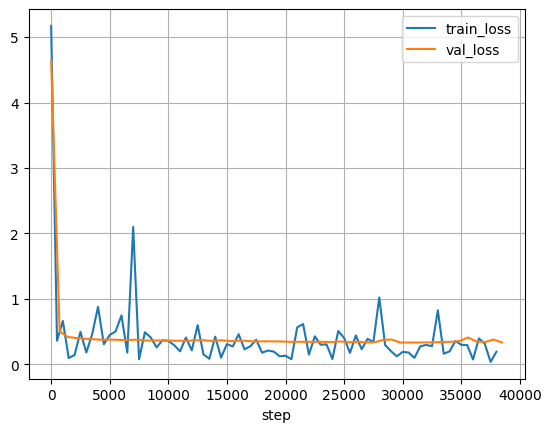

In [39]:
#画线要注意的是损失是不一定在零到1之间的
def plot_learning_curves(record_dict, sample_step=500):
    # build DataFrame
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")

    # plot
    for idx, item in enumerate(train_df.columns):
        plt.plot(train_df.index, train_df[item], label=f"train_{item}")
        plt.plot(val_df.index, val_df[item], label=f"val_{item}")
        plt.grid()
        plt.legend()
        # plt.xticks(range(0, train_df.index[-1], 10*sample_step), range(0, train_df.index[-1], 10*sample_step))
        plt.xlabel("step")

        plt.show()

plot_learning_curves(record)  #横坐标是 steps

测试集

In [40]:
model.eval()
loss = evaluating(model, test_loader, loss_fct)
print(f"loss:     {loss:.4f}")

loss:     0.3527


### homework3：理解激活函数，批归一化，dropout的作用

激活函数  
1. 作用：激活函数是神经网络中的非线性变换，它决定了神经元的输出。如果没有激活函数，神经网络无论有多少层，都只能表示线性变换，无法拟合复杂的非线性关系
2. 常见的激活函数：sigmoid、tanh、ReLU、Leaky ReLU、ELU、softmax、swish等
3. 不同激活函数的优缺点：
    - sigmoid：
        - 公式：$\sigma(x) = \frac{1}{1 + e^{-x}}$
        - 特点：将输入映射到 (0, 1) 之间，适合二分类问题的输出层  
        - 缺点：容易导致梯度消失问题（当输入值很大或很小时，梯度接近 0） 
    - tanh：
        - 公式：$\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$
        - 特点：将输入映射到 (-1, 1) 之间，比 Sigmoid 更常用
        - 缺点：同样存在梯度消失问题
    - ReLU：
        - 公式：$f(x) = max(0, x)$
        - 特点：计算简单，能有效缓解梯度消失问题，是当前最常用的激活函数
        - 缺点：当输入为负数时，梯度为 0，可能导致神经元“死亡”
    - Leaky ReLU：
        - 公式：$f(x) = max(0.01x, x)$
        - 特点：解决了 ReLU 的“死亡”问题，允许负数输入有较小的梯度
        - 缺点：计算量大，不如 ReLU 快
    - ELU：
        - 公式：$f(x) = \begin{cases}x, & x \geq 0 \\ \alpha(e^x - 1), & x < 0 \end{cases}$
        - 特点：在 ReLU 出现“死亡”问题时，提出了一种新的激活函数，可以缓解“死亡”问题
        - 缺点：计算量大，不如 ReLU 快
    - softmax：
        - 公式：$softmax(x_i) = \frac{e^{x_i}}{\sum_{j=1}^K e^{x_j}}$
        - 特点：将输入归一化到 (0, 1) 之间，输出为概率分布，适合多分类问题的输出层
        - 缺点：计算量大，不如 ReLU 快
    - swish：
        - 公式：$f(x) = x \sigma(x)$
        - 特点：将 ReLU 函数与 sigmoid 函数结合，可以有效缓解梯度消失问题，是当前最新的激活函数
        - 缺点：计算量大，不如 ReLU 快

![本地图片示例](./images/Activation Function.png)

批归一化：每层的激活值都做归一化    
1. 作用：批归一化通过对每一层的输入进行标准化（均值为 0，方差为 1），解决内部协变量偏移（Internal Covariate Shift）问题，从而加速训练并提高模型的稳定性
2. 原理：
    - 内部协变量偏移：指的是模型训练过程中，随着网络层数加深，每层的输入分布发生变化，导致每层的输出分布也发生变化，从而影响后续层的学习。
    - 解决方法：通过对每一层的输入进行标准化，使得每层的输入分布变得一致，从而消除内部协变量偏移。
3. 优点：
    - 加速训练：减少了学习率的设置，加快了收敛速度，提高了模型的精度
    - 防止梯度爆炸或消失：通过标准化，使得每层的输入分布变得一致，避免了梯度爆炸或消失，提高了模型的稳定性
4. 减均值除方差：远离饱和区
    - 避免分布数据偏移，远离导数饱和区
    - 但这个处理对于在-1~1之间的梯度变化不大的激活函数，效果不仅不好，反而更差。比如sigmoid函数，s函数在-1~1之间几乎是线性，BN变换后就没有达到非线性变换的目的；而对于relu，效果会更差，因为会有一半的置零。总之换言之，减均值除方差操作后可能会削弱网络的性能
5. 缩放加移位：因此，必须进行一些转换才能将分布从0移开。使用缩放因子γ和移位因子β来执行此操作

dropout：随机失活  
1. 作用：dropout 是深度学习中常用的正则化方法，通过随机让神经元的输出为 0，来减少过拟合。
2. 原理：
    - 训练时，随机让神经元的输出为 0，使得神经网络的某些节点不工作，从而降低了模型的复杂度，提高了模型的泛化能力。
    - 测试时，不让神经元的输出为 0，而是使用全部输入，从而得到更加准确的预测结果。
3. 优点：
    - 减少过拟合：通过随机让神经元的输出为 0，减少了神经网络的复杂度，从而提高了模型的泛化能力，防止了过拟合。
    - 加速训练：减少了学习率的设置，加快了收敛速度，提高了模型的精度。
    - 防止梯度消失或爆炸：通过随机让神经元的输出为 0，使得神经元的输出分布变得更加稳定，防止了梯度消失或爆炸。
4. 缺点：
    - 训练时，神经元的输出为 0，会导致模型的稳定性下降，导致训练时间变长。
    - 训练时，神经元的输出为 0，会导致模型的泛化能力下降，导致模型的预测能力变差。